In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import xgboost as xgb


In [2]:
data = pd.read_csv('puskesmas.csv')
data[['Tekanan Sistolik', 'Tekanan Diastolik']] = data['Tekanan Darah'].str.split('/', expand=True)
data['Tekanan Sistolik'] = data['Tekanan Sistolik'].astype(int)
data['Tekanan Diastolik'] = data['Tekanan Diastolik'].astype(int)
data = data.drop(columns=['Tekanan Darah'])

In [3]:
kategori_columns = ['Jenis Kelamin', 'Riwayat Hipertensi', 'Riwayat Penyakit Jantung', 
                    'Sudah Menikah', 'Riwayat Stroke', 'Riwayat merokok']
for col in data.columns:
    if col not in kategori_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

In [4]:
data['Jenis Kelamin'] = data['Jenis Kelamin'].replace({'Laki-laki':0,'Perempuan':1}).astype(np.uint8)
data['Riwayat Hipertensi'] = data['Riwayat Hipertensi'].replace({'tidak':0,'ya':1}).astype(np.uint8)
data['Riwayat Penyakit Jantung'] = data['Riwayat Penyakit Jantung'].replace({'tidak':0,'ya':1}).astype(np.uint8)
data['Sudah Menikah'] = data['Sudah Menikah'].replace({'tidak':0,'ya':1}).astype(np.uint8)
data['Riwayat Stroke'] = data['Riwayat Stroke'].replace({'tidak':0,'ya':1}).astype(np.uint8)
data['Riwayat merokok'] = data['Riwayat merokok'].replace({'tidak':0,'ya':1}).astype(np.uint8)

/tmp/ipykernel_14012/2592194176.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Jenis Kelamin'] = data['Jenis Kelamin'].replace({'Laki-laki':0,'Perempuan':1}).astype(np.uint8)
/tmp/ipykernel_14012/2592194176.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Riwayat Hipertensi'] = data['Riwayat Hipertensi'].replace({'tidak':0,'ya':1}).astype(np.uint8)
/tmp/ipykernel_14012/2592194176.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behav

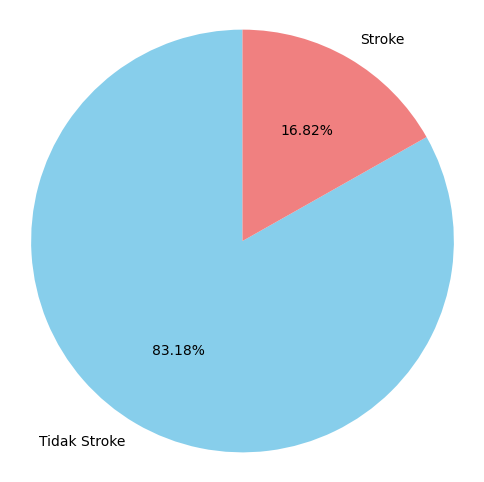

# samples associated with no stroke: 183
# samples associated with stroke: 37


In [5]:
class_occur = data['Riwayat Stroke'].value_counts()
class_names = ['Tidak Stroke','Stroke']
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(class_occur, labels=class_names, autopct='%1.2f%%', startangle=90, colors=['skyblue', 'lightcoral'])
ax.axis('equal')
plt.show()
print("# samples associated with no stroke: {}".format(class_occur[0]))
print("# samples associated with stroke: {}".format(class_occur[1]))

In [6]:
X = data[['Jenis Kelamin', 'Usia', 'Riwayat Hipertensi', 
        'Riwayat Penyakit Jantung', 'Sudah Menikah', 'Berat Badan', 
        'Riwayat merokok', 'Detak Jantung', 'Saturasi Oksigen', 
        'Suhu Tubuh', 'Tekanan Sistolik', 'Tekanan Diastolik']]
y = data['Riwayat Stroke']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
smote = SMOTE()
X_resample, y_resample = smote.fit_resample(X_train, y_train)

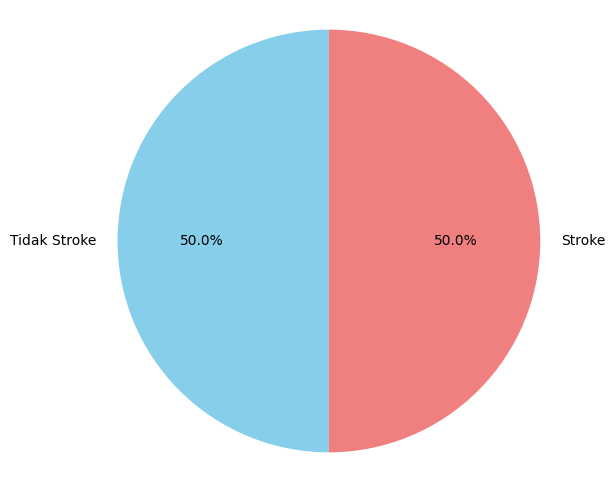

In [8]:
from collections import Counter

distribution = Counter(y_resample)

labels = ['Tidak Stroke', 'Stroke']
counts = [distribution[0], distribution[1]]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.axis('equal')
plt.show()

In [9]:
xgb_clf = xgb.XGBClassifier(random_state=42, n_estimators=100)
xgb_clf.fit(X_resample, y_resample)

y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.9091
Precision: 0.8571
Recall: 0.5455
F1 Score: 0.6667

Confusion Matrix:
[[54  1]
 [ 5  6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        55
           1       0.86      0.55      0.67        11

    accuracy                           0.91        66
   macro avg       0.89      0.76      0.81        66
weighted avg       0.91      0.91      0.90        66



In [10]:
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold (Youden's J): {optimal_threshold:.3f}")
print(f"At this threshold: TPR (sensitivity) = {tpr[optimal_idx]:.3f}, FPR = {fpr[optimal_idx]:.3f}")


Optimal threshold (Youden's J): 0.288
At this threshold: TPR (sensitivity) = 0.727, FPR = 0.036


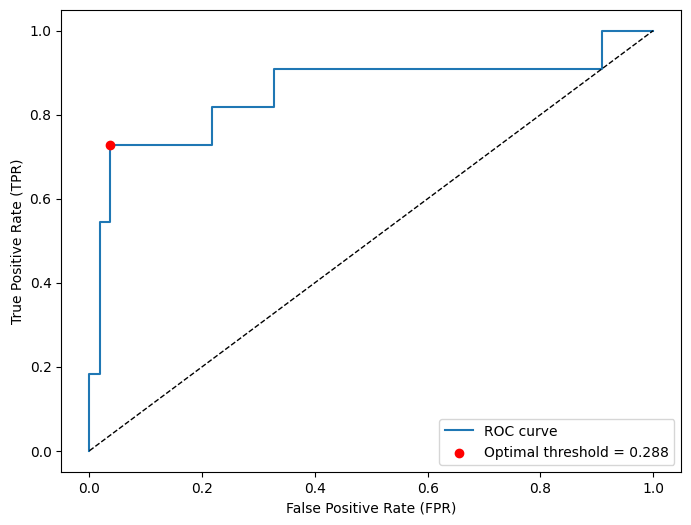

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal threshold = {optimal_threshold:.3f}', zorder=10)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()


In [12]:
# Smote
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

# Confusion matrix
print("Confusion Matrix (Smote):")
print(confusion_matrix(y_test, y_pred_optimal))

# Detailed metrics
print("\nClassification Report (Smote):")
print(classification_report(y_test, y_pred_optimal))

Confusion Matrix (Smote):
[[53  2]
 [ 3  8]]

Classification Report (Smote):
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        55
           1       0.80      0.73      0.76        11

    accuracy                           0.92        66
   macro avg       0.87      0.85      0.86        66
weighted avg       0.92      0.92      0.92        66



In [13]:
import joblib

joblib.dump(xgb_clf, 'xgb_clf_model.pkl')

['xgb_clf_model.pkl']

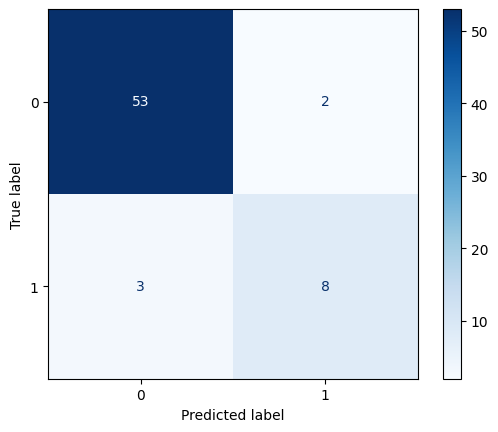

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_optimal, cmap="Blues")

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve

# Assuming these are already defined
# y_proba = clf.predict_proba(X_test)[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test, y_proba)

j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold (Youden's J): {optimal_threshold:.3f}")
print(f"At this threshold: TPR (sensitivity) = {tpr[optimal_idx]:.3f}, FPR = {fpr[optimal_idx]:.3f}")

# Prepare DataFrame
df_roc = pd.DataFrame({
    'Threshold': thresholds,
    'FPR': fpr,
    'TPR': tpr,
    'J_score': j_scores
})

# Save to CSV
df_roc.to_csv('roc_thresholds_xgb.csv', index=False)
print("✅ ROC thresholds CSV saved as 'roc_thresholds_xgb.csv'")


Optimal threshold (Youden's J): 0.288
At this threshold: TPR (sensitivity) = 0.727, FPR = 0.036
✅ ROC thresholds CSV saved as 'roc_thresholds_xgb.csv'
